In [1]:
pip install openseespy

Note: you may need to restart the kernel to use updated packages.


Natural Frequencies: [0.5664797199090008, 1.3759602744284074, 1.945901681383259] Hz
Areas: 29.17304519426734 28.199146542573644 26.25134923918697 24.30355193579958 23.32965328410624 22.355762053497735 20.40797959228037 18.460197131063 17.486305900454497
Inertias: 22541.430965421565 20358.423763756156 16424.467847714568 13033.044242990863 11528.202430473124 10143.908245408302 7716.7999980556615 5711.453676183833 4854.361897970184
Diameters: 78.74016 76.11548 70.86612 65.61676 62.99208 60.36742 55.1181 49.868779999999994 47.244119999999995
No Model_ODB specified, trying to get data from the active model.
3D model


<IPython.core.display.Javascript object>


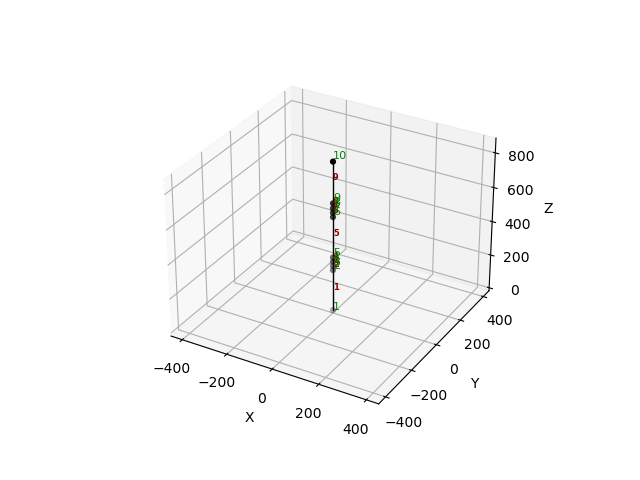

No Model_ODB specified to plot modeshapes
3D model


<IPython.core.display.Javascript object>


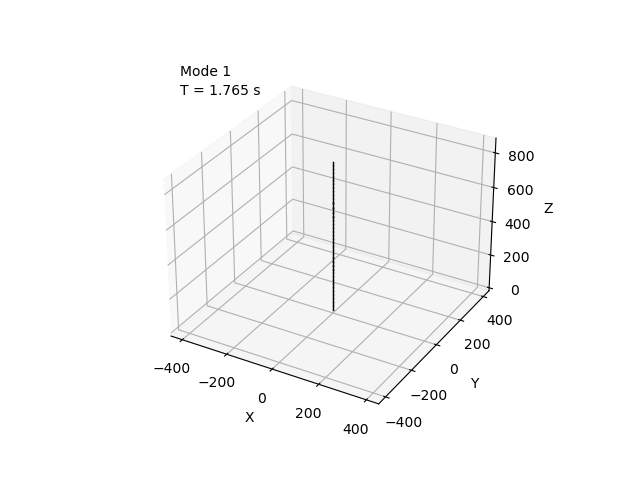

No Model_ODB specified to plot modeshapes
3D model


<IPython.core.display.Javascript object>


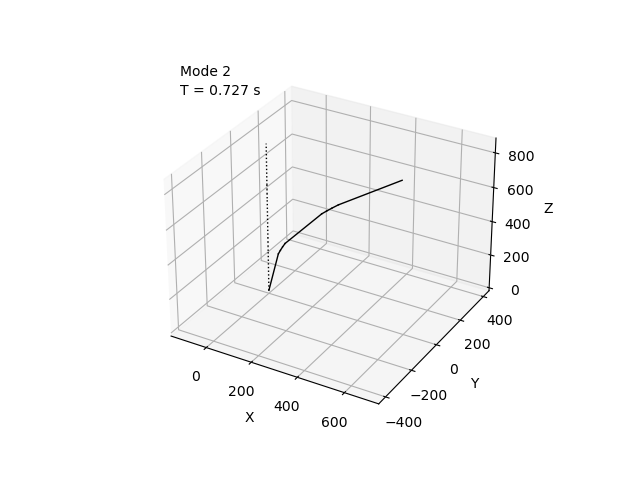

(<Figure size 640x480 with 1 Axes>, <Axes3DSubplot:xlabel='X', ylabel='Y'>)

In [7]:
# following example on http://opensees.berkeley.edu/wiki/index.php/Elastic_Frame_Example
# running dynamic ground motion

%matplotlib notebook

# import OpenSees and libraries
from openseespy.opensees import *
from openseespy.postprocessing.Get_Rendering import *

# numerical and plotting tools
import numpy as np
import matplotlib.pyplot as plt
import math

# system commands
import os, os.path
import glob
import shutil

# -------------------------------
#       Generate Model
# -------------------------------

# remove existing model
wipe()

# remove existing results
# explanation here: https://stackoverflow.com/a/31989328
def remove_thing(path):
    if os.path.isdir(path):
        shutil.rmtree(path)
    else:
        os.remove(path)

def empty_directory(path):
    for i in glob.glob(os.path.join(path, '*')):
        remove_thing(i)

empty_directory('modes')
empty_directory('output')

# ------------------------------------
#   Generate model and static analysis
# ------------------------------------

# set modelbuilder
model('basic', '-ndm', 3, '-ndf', 6)

# units: in, kip, s
# dimensions
ft = 12.0
inch = 1.0
g = 386.1 #in/s^2
kip = 1.0
ksi = kip/(inch**2)

# material properties
Es = 29000*ksi
Gs = 11500*ksi

# create nodes
# command: node(nodeID, x-coord, y-coord, z-coord)
# command: node(nodeTag, *crds, '-ndf', ndf, '-mass', *mass, '-disp', *disp, '-vel', *vel, '-accel', *accel)
# Lower tower section
# node(1, 0.0, 0.0, 0.0)
# node(2, 0.0, 20.0131*ft, 0.0)
# # Tapered lower section (Split into 3 elements)
# node(3, 0.0, 22.0910*ft, 0.0)
# node(4, 0.0, 24.1688*ft, 0.0)
# node(5, 0.0, 26.2467*ft, 0.0)
# # Middle tower section
# node(6, 0.0, 45.9318*ft, 0.0)
# # Tapered middle section (Split into 3 elements)
# node(7, 0.0, 48.0097*ft, 0.0)
# node(8, 0.0, 50.0875*ft, 0.0)
# node(9, 0.0, 52.4934*ft, 0.0)
# # Top tower section
# node(10, 0.0, 72.1785*ft, 0.0)

node(1, 0.0, 0.0, 0.0)
node(2, 0.0, 0.0, 20.0131*ft)
# Tapered lower section (Split into 3 elements)
node(3, 0.0, 0.0, 22.0910*ft)
node(4, 0.0, 0.0, 24.1688*ft)
node(5, 0.0, 0.0, 26.2467*ft)
# Middle tower section
node(6, 0.0, 0.0, 45.9318*ft)
# Tapered middle section (Split into 3 elements)
node(7, 0.0, 0.0, 48.0097*ft)
node(8, 0.0, 0.0, 50.0875*ft)
node(9, 0.0, 0.0, 52.4934*ft)
# Top tower section
node(10, 0.0, 0.0, 72.1785*ft)

# restraints
# command: fix(nodeID, DOF1, DOF2, DOF3, DOF4, DOF5, DOF6) 0 = free, 1 = fixed
# Use a fixed connection for now
fix(1, 1, 1, 1, 1, 1, 1)

# geometric transformation for beam-columns
# command: geomTransf('Type', TransfTag)
# see https://opensees.berkeley.edu/wiki/index.php/Linear_Transformation 
geomTransf('PDelta', 1, 1, 0, 0) #columns

# define elements                                                                              

# Determining areas and area moment of inertias for each section
# Note: Ix = Iy
# Note: Iz = J = 2*Ix

D1 = 6.56168*ft
D5 = 5.24934*ft
D9 = 3.93701*ft

# Bottom tower section
D1 = 6.56168*ft
t1 = 0.019685039*ft
A1 = ((D1/2)**2 - ((D1-t1)/2)**2)*math.pi
I1 = ((D1/2)**4 - ((D1-t1)/2)**4)*math.pi/4
J1 = (math.pi/32)*(D1**4 - (D1-t1)**4)

# Tapered bottom section 1
D2 = (5/6)*(D1-D5) + D5
t2 = t1
A2 = ((D2/2)**2 - ((D2-t2)/2)**2)*math.pi
I2 = ((D2/2)**4 - ((D2-t2)/2)**4)*math.pi/4
J2 = (math.pi/32)*(D2**4 - (D2-t2)**4)

# Tapered bottom section 2
D3 = (1/2)*(D1-D5) + D5
t3 = t1
A3 = ((D3/2)**2 - ((D3-t3)/2)**2)*math.pi
I3 = ((D3/2)**4 - ((D3-t3)/2)**4)*math.pi/4
J3 = (math.pi/32)*(D3**4 - (D3-t3)**4)

# Tapered bottom section 3
D4 = (1/6)*(D1-D5) + D5
t4 = t1
A4 = ((D4/2)**2 - ((D4-t4)/2)**2)*math.pi
I4 = ((D4/2)**4 - ((D4-t4)/2)**4)*math.pi/4
J4 = (math.pi/32)*(D4**4 - (D4-t4)**4)

# Middle tower section
D5 = 5.24934*ft
t5 = t1
A5 = ((D5/2)**2 - ((D5-t5)/2)**2)*math.pi
I5 = ((D5/2)**4 - ((D5-t5)/2)**4)*math.pi/4
J5 = (math.pi/32)*(D5**4 - (D5-t5)**4)

# Tapered middle section 1
D6 = (5/6)*(D5-D9) + D9
t6 = t1
A6 = ((D6/2)**2 - ((D6-t6)/2)**2)*math.pi
I6 = ((D6/2)**4 - ((D6-t6)/2)**4)*math.pi/4
J6 = (math.pi/32)*(D6**4 - (D6-t6)**4)

# Tapered middle section 2
D7 = (1/2)*(D5-D9) + D9
t7 = t1
A7 = ((D7/2)**2 - ((D7-t7)/2)**2)*math.pi
I7 = ((D7/2)**4 - ((D7-t7)/2)**4)*math.pi/4
J7 = (math.pi/32)*(D7**4 - (D7-t7)**4)

# Tapered middle section 3
D8 = (1/6)*(D5-D9) + D9
t8 = t1
A8 = ((D8/2)**2 - ((D8-t8)/2)**2)*math.pi
I8 = ((D8/2)**4 - ((D8-t8)/2)**4)*math.pi/4
J8 = (math.pi/32)*(D8**4 - (D8-t8)**4)

# Top tower section
D9 = 3.93701*ft
t9 = t1
A9 = ((D9/2)**2 - ((D9-t9)/2)**2)*math.pi
I9 = ((D9/2)**4 - ((D9-t9)/2)**4)*math.pi/4
J9 = (math.pi/32)*(D9**4 - (D9-t9)**4)


# create elastic beam-column elements - 
# command: element('elasticBeamColumn', eleTag, *eleNodes, Area, E_mod, G_mod, Jxx, Iy, Iz, transfTag, <'-mass', mass>, <'-cMass'>)
# define the columns                                      

# Distributed Weights are input below in units of kip/in
# Cylindrical sections => Ix = Iy 
# Cylindrical sections => J = Iz = 2*Ix = (D^4-(D-t)^4)*(pi/32) 

element('elasticBeamColumn', 1, 1, 2, A1, Es, Gs, J1, I1, J1, 1, '-mass', (0.012693/g)*kip/inch) # Bottom Tower Section
element('elasticBeamColumn', 2, 2, 3, A2, Es, Gs, J2, I2, J2, 1, '-mass', (0.049073/g)*kip/inch)
element('elasticBeamColumn', 3, 3, 4, A3, Es, Gs, J3, I3, J3, 1, '-mass', (0.045678/g)*kip/inch)
element('elasticBeamColumn', 4, 4, 5, A4, Es, Gs, J4, I4, J4, 1, '-mass', (0.042283/g)*kip/inch)
element('elasticBeamColumn', 5, 5, 6, A5, Es, Gs, J5, I5, J5, 1, '-mass', (0.010146/g)*kip/inch)
element('elasticBeamColumn', 6, 6, 7, A6, Es, Gs, J6, I6, J6, 1, '-mass', (0.038888/g)*kip/inch)
element('elasticBeamColumn', 7, 7, 8, A7, Es, Gs, J7, I7, J7, 1, '-mass', (0.035493/g)*kip/inch)
element('elasticBeamColumn', 8, 8, 9, A8, Es, Gs, J8, I8, J8, 1, '-mass', (0.032098/g)*kip/inch)
element('elasticBeamColumn', 9, 9, 10, A9, Es, Gs, J9, I9, J9, 1, '-mass', (0.0076/g)*kip/inch)

# assign additional masses
# masses only act at nodes that have DoF
# command: mass(nodeID, dx, dy, dz, r@x, r@y, r@z)

### to-do: rotational inertia for a point mass: I = mr^2
whub = 9.3*kip
mhub = whub/g #kip*s^2/in
### to-do: the box is slightly higher than the last node of the tower, should we add another node? how would it be connected to the rest of the tower?
hhub = 74.14698*ft # height of hub

### to-do: what does mass x vs mass y mean?
mass(10, mhub, mhub, mhub, 0.0, 0.0, mhub*(hhub**2))

# -------------------------------
#       Perform eigen analysis
# -------------------------------

numEigen = 3
eigenValues = eigen(numEigen)

wn = [i ** 0.5 for i in eigenValues]
fn = [i / (2*math.pi) for i in wn]

print("Natural Frequencies:", fn, "Hz")


print("Areas:", A1, A2, A3, A4, A5, A6, A7, A8, A9)
print("Inertias:", I1, I2, I3, I4, I5, I6, I7, I8, I9)
print("Diameters:", D1, D2, D3, D4, D5, D6, D7, D8, D9)


#### Display the active model with node and element tags
plot_model("nodes","elements")

plot_modeshape(1, 100)
plot_modeshape(2, 100)

